Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [27]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [15]:
print(tf.__version__)

2.8.0


In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = 'gdrive/My Drive/cnn/data'
data_dir_train = pathlib.Path(root_path + "/Train")
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [42]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

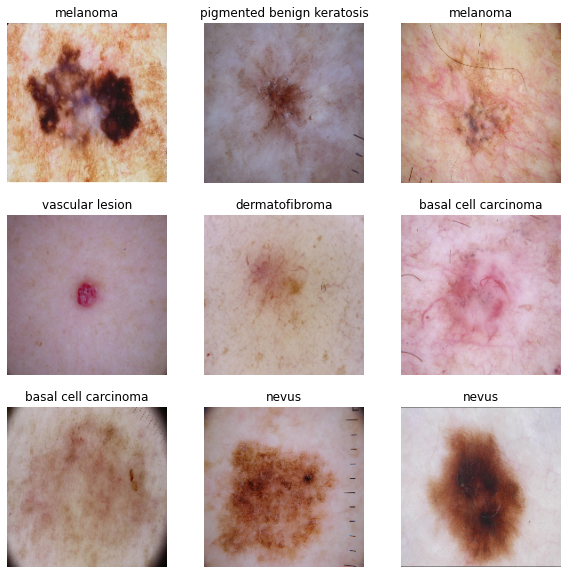

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for imgs, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

in_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=in_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=in_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Train the model

In [22]:
epochs = 20
batch_size = 32
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 503ms/step - loss: -49562.7773 - accuracy: 0.1719 - val_loss: -40572.9492 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 8s 145ms/step - loss: -709827.3125 - accuracy: 0.1724 - val_loss: -658417.2500 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 8s 145ms/step - loss: -2938746.7500 - accuracy: 0.1724 - val_loss: -3108357.7500 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 8s 145ms/step - loss: -7485545.0000 - accuracy: 0.1724 - val_loss: -9360568.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 8s 144ms/step - loss: -14909819.0000 - accuracy: 0.1724 - val_loss: -20533878.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 8s 145ms/step - loss: -26077634.0000 - accuracy: 0.1724 - val_loss: -27189212.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 8s 145ms/step

### Visualizing training results

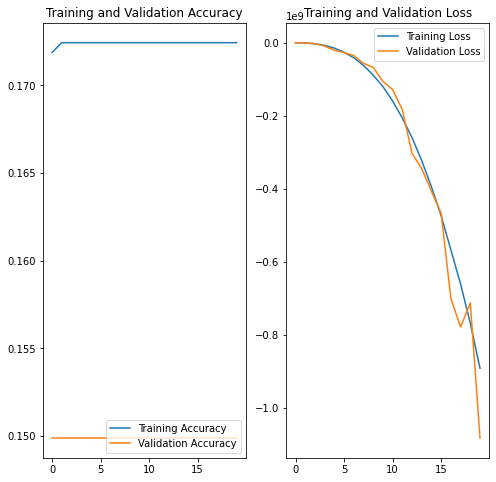

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [26]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)


# Thus we can clearly say that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 1s 41ms/step - loss: -1081983360.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -1059865152.0
Validation Loss -1081983360.0


In [32]:
data_gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_classes = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = data_gen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_classes,
    batch_size = 64
)

valid_batches = data_gen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_classes,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


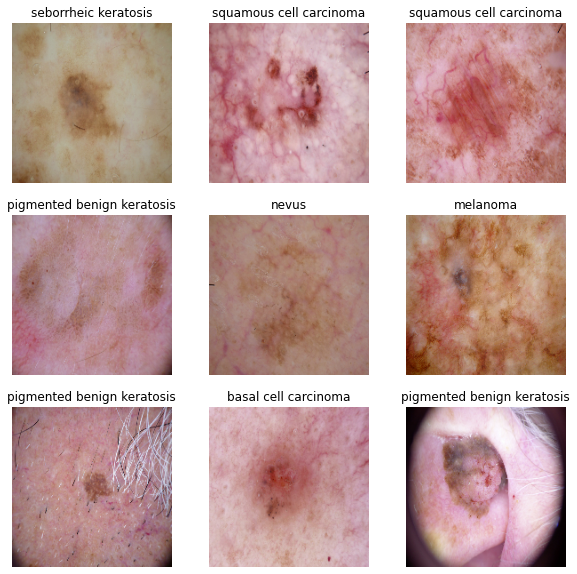

In [33]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [43]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

### Compiling the model

In [44]:
## Your code goes here
model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

### Training the model

In [45]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 59ms/step - loss: 2.2301 - accuracy: 0.2349 - val_loss: 1.7902 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 3s 53ms/step - loss: 1.7723 - accuracy: 0.3633 - val_loss: 1.6486 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6339 - accuracy: 0.4113 - val_loss: 1.5488 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 3s 53ms/step - loss: 1.5386 - accuracy: 0.4693 - val_loss: 1.6964 - val_accuracy: 0.4273
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4955 - accuracy: 0.4693 - val_loss: 1.4752 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4587 - accuracy: 0.4838 - val_loss: 1.4282 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.4091 - accuracy: 0.5022 - val_loss: 1.4340 - val_accuracy: 0.4899
Epoch 8/20
56

### Visualizing the results

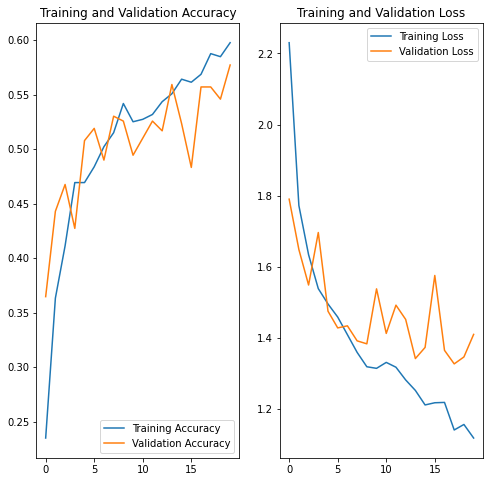

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings:** Our model is overfitting, yet it is significantly more accurate than prior models. When compared to the prior model, there is definitely an improvement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [47]:
## Your code goes here.

In [48]:
train_ds1 = tf.keras.utils.image_dataset_from_directory(
    data_dir_train, 
    batch_size=batch_size, 
    image_size=(img_height,img_width), 
    seed=123)
train_ds1.class_names

Found 2239 files belonging to 9 classes.


['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [49]:
for i in range(9):
    print(train_ds1.class_names[i] + ' ' + str(len(list(data_dir_train.glob(train_ds1.class_names[i] + '/*')))))

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
**Ans. seborrheic keratosis**

#### - Which classes dominate the data in terms proportionate number of samples?
**Ans. pigmented benign keratosis, basal cell carcinoma and nevus.**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [50]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [55]:
path_to_training_dataset = root_path + "/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D872092D0>: 100%|██████████| 500/500 [00:21<00:00, 22.74 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D88201550>: 100%|██████████| 500/500 [00:22<00:00, 21.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D88BB4150>: 100%|██████████| 500/500 [00:24<00:00, 20.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5D872814D0>: 100%|██████████| 500/500 [01:38<00:00,  5.07 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5D82F67610>: 100%|██████████| 500/500 [01:35<00:00,  5.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E83A1CF90>: 100%|██████████| 500/500 [00:36<00:00, 13.53 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5E7B035BD0>: 100%|██████████| 500/500 [00:50<00:00,  9.96 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D87218810>: 100%|██████████| 500/500 [00:23<00:00, 21.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/cnn/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E82638450>: 100%|██████████| 500/500 [00:23<00:00, 21.60 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [56]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [59]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/cnn/data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_81941915-67a3-4b5f-831b-57c035d7697f.jpg',
 'gdrive/My Drive/cnn/data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_d996d2ee-1a4b-4979-a6d0-2c73a8c0d334.jpg',
 'gdrive/My Drive/cnn/data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_a8e91522-2b0e-4e0a-87b4-adeffd2cadb7.jpg',
 'gdrive/My Drive/cnn/data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_61fdbad9-1297-48c6-9b86-df60e81e1b71.jpg',
 'gdrive/My Drive/cnn/data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_98d97376-50d2-4c59-99aa-cca6d6d3f0eb.jpg',
 'gdrive/My Drive/cnn/data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_ebfe9618-f51f-4bdb-a723-f93eb76c0f30.jpg',
 'gdrive/My Drive/cnn/data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_4f01a0d0-d477-45c6-a420-a185

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [62]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [63]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [64]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [65]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [69]:
data_dir_train = pathlib.Path(root_path + "/Train")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [70]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [71]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(padding='same'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [72]:
## your code goes here
model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

#### **Todo:**  Train your model

In [73]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 40s 226ms/step - loss: 1.9837 - accuracy: 0.2552 - val_loss: 1.7020 - val_accuracy: 0.3675
Epoch 2/50
169/169 [==============================] - 39s 226ms/step - loss: 1.5911 - accuracy: 0.3915 - val_loss: 1.4930 - val_accuracy: 0.4469
Epoch 3/50
169/169 [==============================] - 40s 227ms/step - loss: 1.4528 - accuracy: 0.4518 - val_loss: 1.3318 - val_accuracy: 0.4989
Epoch 4/50
169/169 [==============================] - 39s 225ms/step - loss: 1.3593 - accuracy: 0.4828 - val_loss: 1.2901 - val_accuracy: 0.5323
Epoch 5/50
169/169 [==============================] - 39s 226ms/step - loss: 1.2965 - accuracy: 0.5076 - val_loss: 1.2997 - val_accuracy: 0.5308
Epoch 6/50
169/169 [==============================] - 39s 226ms/step - loss: 1.2637 - accuracy: 0.5211 - val_loss: 1.3661 - val_accuracy: 0.4952
Epoch 7/50
169/169 [==============================] - 39s 225ms/step - loss: 1.1979 - accuracy: 0.5406 - val_loss: 1.2142 - val_ac

#### **Todo:**  Visualize the model results

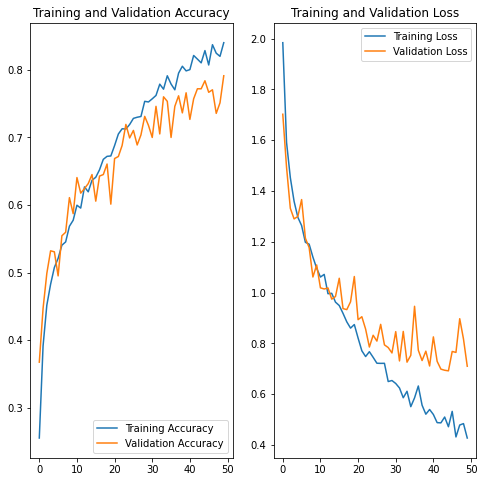

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Analysis: We can see from the graph above that we have decreased the issue of overfitting. Yes, the rebalancing of the classes helped to reduce overfitting.**